## 데이터 준비와 확인

## 데이터 준비와 확인

In [19]:
import tensorflow as tf
import os
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [33]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [26]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [27]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

In [28]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [34]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


## 모델 구성 및 validation set 구성

### LSTM

In [322]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [257]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [258]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 2s 24ms/step - loss: 0.6868 - accuracy: 0.6446 - val_loss: 0.6705 - val_accuracy: 0.7228
Epoch 2/10
34/34 [==============================] - 0s 11ms/step - loss: 0.6030 - accuracy: 0.7703 - val_loss: 0.5176 - val_accuracy: 0.7727
Epoch 3/10
34/34 [==============================] - 0s 12ms/step - loss: 0.4625 - accuracy: 0.8123 - val_loss: 0.4253 - val_accuracy: 0.8245
Epoch 4/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3868 - accuracy: 0.8444 - val_loss: 0.3745 - val_accuracy: 0.8405
Epoch 5/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3476 - accuracy: 0.8570 - val_loss: 0.3550 - val_accuracy: 0.8480
Epoch 6/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3274 - accuracy: 0.8658 - val_loss: 0.3475 - val_accuracy: 0.8498
Epoch 7/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3166 - accuracy: 0.8706 - val_loss: 0.3452 - val_accuracy: 0.8517
Epoch 8/10
34

In [259]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3615 - accuracy: 0.8458
[0.361528605222702, 0.8458408713340759]


In [260]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


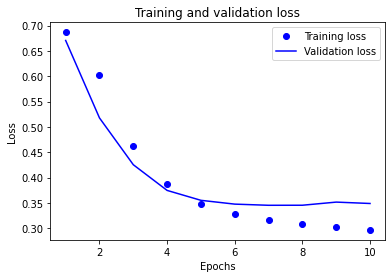

In [261]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

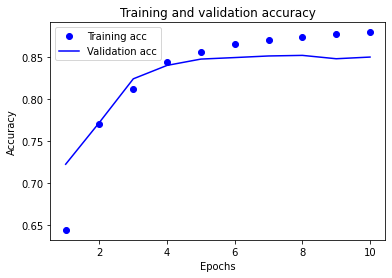

In [262]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

LSTM layer, batch_size, epoch값을 변경하면서 해봤다.

LSTM layer는 8->16으로 변경될때는 그래프로 봤을때 변경이 눈에 띄었지만 16->32로 변경했을때는 큰 변화는 없었다.

batch_size는 512,1024, 2048, 4096, 8192 4개의 값으로 변경하면서 해주었는데 4096으로 변경했을때까지는 변화가 있었지만 8192로 변경했을때는 loss값의 결과는 비슷했지만 감소폭이 작아졌다.

epoch값은 20으로 처음에 돌려봤지만 10이상으로 넘어가면 train값과 val값의 이격이 커져 무의미했다.

### 1-D CNN

In [309]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

In [310]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 1s 18ms/step - loss: 0.6897 - accuracy: 0.5736 - val_loss: 0.6746 - val_accuracy: 0.7173
Epoch 2/10
34/34 [==============================] - 0s 11ms/step - loss: 0.5864 - accuracy: 0.7733 - val_loss: 0.4607 - val_accuracy: 0.8048
Epoch 3/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3978 - accuracy: 0.8288 - val_loss: 0.3699 - val_accuracy: 0.8368
Epoch 4/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3400 - accuracy: 0.8561 - val_loss: 0.3524 - val_accuracy: 0.8445
Epoch 5/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3176 - accuracy: 0.8669 - val_loss: 0.3484 - val_accuracy: 0.8468
Epoch 6/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3034 - accuracy: 0.8731 - val_loss: 0.3470 - val_accuracy: 0.8476
Epoch 7/10
34/34 [==============================] - 0s 10ms/step - loss: 0.2916 - accuracy: 0.8800 - val_loss: 0.3497 - val_accuracy: 0.8475
Epoch 8/10
34

In [311]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3695 - accuracy: 0.8463
[0.36949822306632996, 0.8463494777679443]


In [312]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


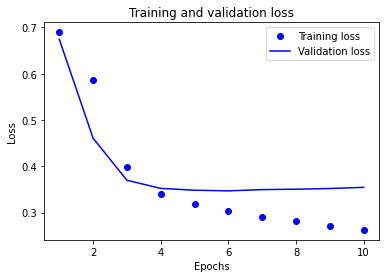

In [313]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

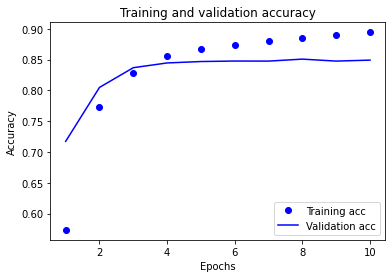

In [314]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

batch_size와 epoch값을 변경하면서 진행하였다.

epoch값은 위의 LSTM모델과 같이 10이상이 되면 이격이 생겨 무의미해졌다.

batch_size값도 LSTM모델과 유사했다. 4096->8192로 변경했을때 loss값의 결과는 비슷하게 나왔지만 감소폭은 증가하였다. 

## GlobalMaxPooling1D

In [323]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


In [324]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 1s 8ms/step - loss: 0.6888 - accuracy: 0.5850 - val_loss: 0.6827 - val_accuracy: 0.6651
Epoch 2/10
34/34 [==============================] - 0s 5ms/step - loss: 0.6695 - accuracy: 0.7221 - val_loss: 0.6509 - val_accuracy: 0.7657
Epoch 3/10
34/34 [==============================] - 0s 5ms/step - loss: 0.6240 - accuracy: 0.7903 - val_loss: 0.5937 - val_accuracy: 0.7978
Epoch 4/10
34/34 [==============================] - 0s 5ms/step - loss: 0.5583 - accuracy: 0.8130 - val_loss: 0.5248 - val_accuracy: 0.8092
Epoch 5/10
34/34 [==============================] - 0s 5ms/step - loss: 0.4854 - accuracy: 0.8273 - val_loss: 0.4574 - val_accuracy: 0.8226
Epoch 6/10
34/34 [==============================] - 0s 5ms/step - loss: 0.4220 - accuracy: 0.8393 - val_loss: 0.4098 - val_accuracy: 0.8289
Epoch 7/10
34/34 [==============================] - 0s 5ms/step - loss: 0.3786 - accuracy: 0.8489 - val_loss: 0.3826 - val_accuracy: 0.8351
Epoch 8/10
34/34 [==

In [325]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3659 - accuracy: 0.8403
[0.3658599555492401, 0.8402872681617737]


In [326]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


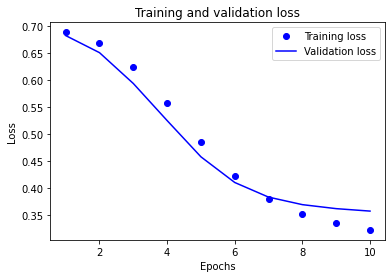

In [327]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

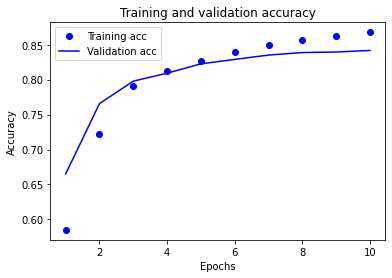

In [328]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마찬가지로 위의 두 모델 LSTM과 1-D CNN과 비슷한 결과가 나왔다.

## Word2Vec적용

In [378]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']

In [379]:
word2vec.similar_by_word("late")

[('early', 0.8121284246444702),
 ('mid', 0.6253470778465271),
 ('Late', 0.6140714287757874),
 ('After_inventing_microarray', 0.49053576588630676),
 ('primetime_daytime', 0.46642735600471497),
 ('Early', 0.4525700807571411),
 ('sometime', 0.4448269009590149),
 ('after', 0.44440266489982605),
 ('last', 0.4426024556159973),
 ('until', 0.4343433976173401)]

In [388]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [381]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 16)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_69 (Dense)             (None, 1)               

In [382]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 2s 41ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6908 - val_accuracy: 0.5200
Epoch 2/10
34/34 [==============================] - 1s 35ms/step - loss: 0.6844 - accuracy: 0.6050 - val_loss: 0.6725 - val_accuracy: 0.6462
Epoch 3/10
34/34 [==============================] - 1s 35ms/step - loss: 0.6262 - accuracy: 0.7023 - val_loss: 0.5543 - val_accuracy: 0.7421
Epoch 4/10
34/34 [==============================] - 1s 35ms/step - loss: 0.4885 - accuracy: 0.7799 - val_loss: 0.4415 - val_accuracy: 0.8001
Epoch 5/10
34/34 [==============================] - 1s 35ms/step - loss: 0.4075 - accuracy: 0.8196 - val_loss: 0.3915 - val_accuracy: 0.8259
Epoch 6/10
34/34 [==============================] - 1s 35ms/step - loss: 0.3663 - accuracy: 0.8415 - val_loss: 0.3780 - val_accuracy: 0.8287
Epoch 7/10
34/34 [==============================] - 1s 35ms/step - loss: 0.3457 - accuracy: 0.8521 - val_loss: 0.3577 - val_accuracy: 0.8442
Epoch 8/10
34

In [383]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3863 - accuracy: 0.8329
[0.3863116502761841, 0.8328620791435242]


In [384]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


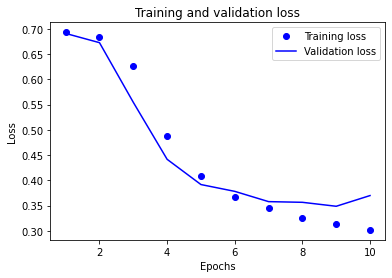

In [385]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

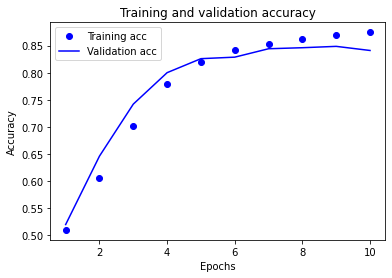

In [386]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고

제출당일에 내는데도 제대로 이해를 못했다. 임베딩과 워드벡터에 대한 이해가 부족하다. 이 부분에 대해서는 추가적인 공부가 필요하다. 공부를 하고 다시 진행해봐야겠다.
익스5에 시간을 갈아넣다 보니 이번 프로젝트는 이틀정도밖에 하지 않았다. 시간이 조금만 더 있었다면 정확도 85%를 넘길 수 있었을 거 같은데 아쉽다.
회고를 쓸 때마다 드는 생각이지만 너무 아쉽다. 조금만 더 하면 될거 같은데. 조금만 더 시간이 있었으면 할 수 있었을텐데. 부족한 부분이 너무 많다. 다행히 시간이 지남에 따라 아는건 많아지고 있다. 그에 따라 재미도 붙이고 있다. 자연스레 할애하는 시간이 늘어나고 있다. 다음에는 더 잘해봐야겠다.